# Self-Driving Car Engineer Nanodegree


## Project 3: Behavioral Cloning
August 2017


---

## Goal
The goal of this project is to build a machine learning model that can successfully steer a car around a race track that it's never encountered before.

The details for this project are located here at [Udacity's Github repo](https://github.com/udacity/CarND-Behavioral-Cloning-P3). My implementation of the project can be found [here at my Github repo](https://github.com/tommytracey/udacity/tree/master/self-driving-nano/projects/3-behavioral-cloning).


---
## Initial Setup

#### Import Modules

In [1]:
import csv
import cv2
import keras
import keras.backend
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm



Using TensorFlow backend.


#### Verify that Keras is using Tensforflow backend

The Keras backend uses Theano by default and changing it to Tensorflow can be tricky via Jupyter. Simply updating the config json file `$HOME/.keras/keras.json` as directed in [Keras backend documentation](https://keras.io/backend/) did not work for me. Trying to set it _before or after loading the notebook_ did not work eithter when using:

`$ os.environ["KERAS_BACKEND"]="tensorflow"`

The only way I could reliably set Tensorflow as the backend was to use the following command **UPON loading the notebook**:

`$ KERAS_BACKEND=tensorflow jupyter notebook`

(NOTE: You can also append `--NotebookApp.iopub_data_rate_limit=10000000000` to the above command if your notebook includes a lot of visualizations. This will help prevent the kernel from crashing and/or causing you to lose your connection to your AWS EC2 instance.)

Re: the backend, **the cell below only provides a sanity check that the backend is configured as expected**. Note that the version of Tensorflow being used by Keras may be different than the one you typically run in your environment. 

[This post](https://www.nodalpoint.com/switch-keras-backend/) by Christos-Iraklis Tsatsoulis provides even more detail if you'd like to further understand the issues and automate the setup process.

In [ ]:
print('Keras version: ', keras.__version__)
print('Tensorflow version: ', tf.__version__)
print('Keras backend: ', keras.backend.backend())
print('keras.backend.image_dim_ordering = ', keras.backend.image_dim_ordering())

os.environ["KERAS_BACKEND"] = "tensorflow"
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("\nBackend OK")

---
# Step 1: Load and preview the data

---

### Original Data Set (provided by Udacity)

In [2]:
# Load UDACITY data into a list
with open('data/udacity/driving_log.csv', newline='') as f:
    udacity_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))
    
# Load UDACITY data from .csv and preview it in Pandas dataframe
udacity_df = pd.read_csv('data/udacity/driving_log.csv', header=0)

print('total rows: ', len(udacity_df))
udacity_df.head()

total rows:  8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### New Data Set (with addition of self-generated data)

In [68]:
# Load data into list
with open('data/track1/driving_log.csv', newline='') as f:
    track1_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

# Load data from .csv and preview it in Pandas dataframe
track1_df = pd.read_csv('data/track1/driving_log.csv', header=0)

print('total rows: ', len(track1_df))
track1_df.head()

total rows:  15128


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


#### Data Set: Initial Observations
We can see from the table above that the driving data includes:
- relative paths to .jpg images from three different camera angles (center, left, right)
- floating point measurements of the vehicle's steering angle, throttle, brake, and speed
- the data appears to be time series, although no time stamps are included

## Preview the driving images

The driving images are the training features for our model. We need to look at samples of these images and start thinking about how various characteristics might affect the model (positively or negatively). 

In [59]:
## Preview a random set of images from each camera angle

index = random.randint(0, len(udacity_df))
img_dir = 'data/udacity/'

center_img_orig = mpimg.imread(img_dir + udacity_data[index][0])
left_img_orig = mpimg.imread(img_dir + udacity_data[index][1])
right_img_orig = mpimg.imread(img_dir + udacity_data[index][2])

center_steer = udacity_data[index][3]

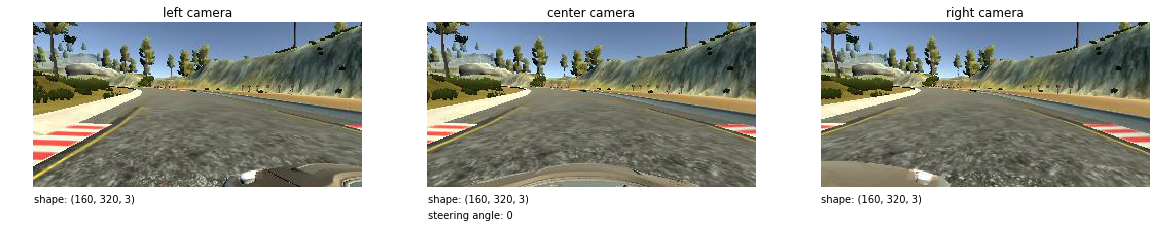

In [5]:
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.text(0, left_img_orig.shape[0]+15, ('shape: ' + str(left_img_orig.shape)))
plt.imshow(left_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.text(0, center_img_orig.shape[0]+15, ('shape: ' + str(center_img_orig.shape)))
plt.text(0, center_img_orig.shape[0]+30, ('steering angle: ' + center_steer))
plt.imshow(center_img_orig, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.text(0, right_img_orig.shape[0]+15, ('shape: ' + str(right_img_orig.shape)))
plt.imshow(right_img_orig, cmap="gray")

#### Driving Images: Initial Observations
We can see from the images above that:
- the images are taken in the front of the car (no side or rear angles)
- each image is 160x320 with 3 RGB color channels
- there is quite a bit of superfluous data, i.e. data that won't benefit the model; for example the sky, hills, trees in the background, as well as the hood of the car).

If you view enough images or actually run the simulator, you also see that:
- there are a lot of turns in the road (duh!), but since the track ultimately ends where it started, there seems to be more turns in one direction than the other
- the lane markings change shape and color at different points in the track, and at some points there are no markings at all!
- all of the images are consistently bright; no glare, no darkness, and no shadows that you'd usually encounter with normal driving

Given the simulation takes place on a race track (not a highway), the road is free of additional cars, traffic signs, lanes, etc. We won't account for these in this project, but a more robust driving model would need training data that included these conditions. 

That said, many of the other items above can create biases in our model and cause it to overfit the specific driving conditions within this particular simulation. We need to correct for these so that our model learns to drive in a variety of conditions we might find on other tracks. We'll do this by pre-processing and augmenting our training data throughout the sections to follow. But first let's look at our target data (steering angles) to see if there's anything else we need to correct for. 

## Examine the steering angles
The steering angles are our target data for training the model. That is, based on the images fed into the model while the car is driving along the track, the model will predict the appropriate steering angle to navigate the patch of road ahead.

In [60]:
## Steering angle distribution function

def show_dist(angles):
    angles = np.array(angles)
    num_bins = 35    
    avg_per_bin = len(angles) / num_bins
    
    print('Total records:', angles.shape[0])
    print('Avg per bin: {:0.1f}'.format(avg_per_bin))
    
    hist, bins = np.histogram(angles, num_bins)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    plt.title('Distribution of Steering Angles')
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(angles), np.max(angles)), (avg_per_bin, avg_per_bin), 'k-')
    plt.show()


#### Distribution &mdash; Udacity Data

Total records: 8036
Avg per bin: 229.6


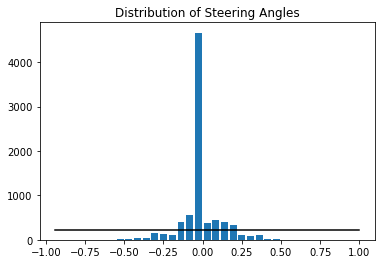

In [61]:
angles = udacity_df.steering.tolist()
show_dist(angles)


**Steering Angle Observations**:

We can see from the graph above that an overwhelming amount of the target data are steering angles close to zero (i.e., when the car is driving straight). This biases our model to drive the car straight and make it's difficult to learn how to navigate turns. 

It also seems there may be an imbalance in left vs. right turning data (although not as much as I had expected). It's not clear how big of an impact this would have on the model, but there's a chance the model could learn to turn more effectively in one direction than the other. Just to be safe we'll correct for this by ensuring there are equal quantities of left and right steering data after pre-processing. 

#### Distribution &mdash; Self-generated data + Udacity data

Total records: 15128
Avg per bin: 432.2


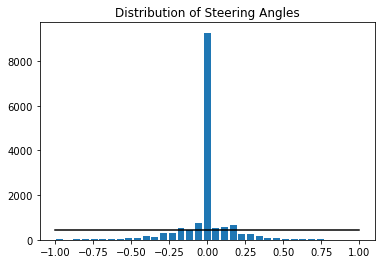

In [63]:
angles = track1_df.steering.tolist()
show_dist(angles)

---
# Step 2: Data pre-processing
---

### 2.1 | Overview of Data Sources and Splits

**Data Sources**: 
- There are two tracks, but all of the original training and validation data is generated by driving the simulator on **Track 1**.
- Udacity provides an intial set of "good" data to get us started.
- Additional data is gathered by running the simulator myself. 

**Training Data**:
- The training data set includes the original image data captured from the simulator on Track 1, plus any additional data generated via pre-processing and augmentation. 

**Validation Data**:
- The validation data will contain the original image data captured from the simulator on Track 1, with only a pre-process to create a more balanced distribution (i.e., reduce the 'drive straight' bias). No other pre-processing or augmentation is included. This ensures we can properly validate whether changes we're making to the model or training data are increasing or decreasing the model's performance. 

**Test Data**:
- We'll test the model's ability to generalize by running it on **Track 2**. So, the simulator input images from Track 2 will serve as our test data.

In [69]:
## Set data sources

sources = ['udacity', 'self', 'track1']
default_source = sources[2]

## Function to reference image directory for a given source
def get_img_dir(source):
    return "data/" + source + "/IMG/"


### 2.2 | Data Hygiene

Before going any further there are few aspects of the data we need to cleanup to make the data easier to work with.

1. We're only using the steering data to train the model, so we can prune out the other measurements (throttle, brake, and speed).
2. Remove the directory from image path data. We'll be moving our data around and we only want the image filename. 
3. Cast all of the steering data as floats. In the .csv they're cast as strings. 

In [10]:
## Hygiene function




#### Track 1 data hygiene

In [92]:
# column references for source data: 
# 0=center_img, 1=left_img, 2=right_img, 3=steering, 4=throttle, 5=brake, 6=speed

track1_clean = []

for row in track1_data[1:]:
    # Remove directory from image paths
    center = row[0].split('/')[-1]
    left = row[1].split('/')[-1]
    right = row[2].split('/')[-1]
    
    # Only grab the steering data and cast as float
    angle = float(row[3])
    
    track1_clean.append([center, left, right, angle])

print('number of records: ', len(track1_clean))
print('\nfirst 3 records:\n', track1_clean[0:3])

number of records:  15128

first 3 records:
 [['center_2016_12_01_13_30_48_287.jpg', 'left_2016_12_01_13_30_48_287.jpg', 'right_2016_12_01_13_30_48_287.jpg', 0.0], ['center_2016_12_01_13_30_48_404.jpg', 'left_2016_12_01_13_30_48_404.jpg', 'right_2016_12_01_13_30_48_404.jpg', 0.0], ['center_2016_12_01_13_31_12_937.jpg', 'left_2016_12_01_13_31_12_937.jpg', 'right_2016_12_01_13_31_12_937.jpg', 0.0]]


### 2.3 | Seperate C/L/R camera data and adjust steering angles for left and right turns
Right now, each row of the data set contains three camera angles (center, left, right) and one steering angle which pertains to the center camera. In order to utilize all of the different camera data, we need to: 

1. Separate the data for each of the different camera angles (only one camera angle per row)
2. Adjust the steering angles for the left and right cameras _while the car is turning_. This will compensate for their respective vantage points relative to the center of the car. That is, the steering angle for a right turn should be sharper from the persective of the left camera (and vice versa). 

In [101]:
turn_thresh = 0.15   # the angle threshold used to identify left and right turns
ang_corr = 0.27   # the steering angle correction for left and right cameras


def steer_adj(angle):
    '''Calculates the absolute value of the steering angle correction for images from 
    the left and right cameras.
    '''
    new_angle = min((abs(angle)+ang_corr), 1)
    
    return new_angle


In [102]:
## Function for adding left and right camera angles




In [103]:
track1_3cam = []
source = 'track1'

for row in track1_clean:
    img_center, ang_center = row[0], row[3]  # center camera with original steering angle
    
    # capture right turn data
    if ang_center > turn_thresh:
        # center camera, orig steering angle
        track1_3cam.append([img_center, ang_center, source]) 
        
        # left camera, adjusted steering angle
        img_left, ang_left = row[1], steer_adj(row[3])
        track1_3cam.append([img_left, ang_left, source])
        
    # capture left turn data
    elif ang_center < -turn_thresh:
        # center camera, orig steering angle
        track1_3cam.append([img_center, ang_center, source]) 
        
        # right camera, adjusted steering angle
        img_right, ang_right = row[1], -steer_adj(row[3])  
        track1_3cam.append([img_right, ang_right, source])
        
    # capture straight driving data
    else: 
        if ang_center == 0:
            rand = random.randint(1, 10)
            # keep only a fraction to help normalize the distribution
            if rand == 1:   
                track1_3cam.append([img_center, ang_center, source])
        else:
            track1_3cam.append([img_center, ang_center, source])

Total records: 10330
Avg per bin: 295.1


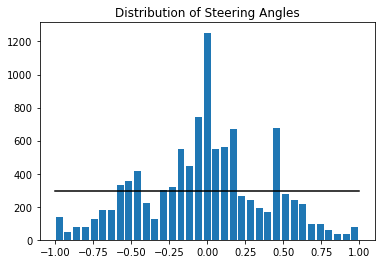

In [104]:
angles = [i[1] for i in track1_3cam]
show_dist(angles)

### 2.4 | Crop & Flip

In [19]:
## Define cropping dimensions

# Crop settings provided to Keras Cropping2D layer
crop_set = (60, 20), (20, 20)   # number of pixels to remove from (top, bottom), (left, right)
    
# Define image shapes 
orig_shape = center_img_orig.shape  # (160, 320, 3)
crop_shape = (
    orig_shape[0]-(crop_set[0][0]+crop_set[0][1]), \
    orig_shape[1]-(crop_set[1][0]+crop_set[1][1]),  \
    orig_shape[2]
)

# Define resulting crop points for preview cell below
h1, h2 = (crop_set[0][0], orig_shape[0]-crop_set[0][1])
w1, w2 = (crop_set[1][0], orig_shape[1]-crop_set[1][1])


print('orig_shape: ', orig_shape)
print('crop_shape: ', crop_shape)
print('crop points [h1:h2,w1:w2] = [{}:{},{}:{}]'.format(h1, h2, w1, w2))

orig_shape:  (160, 320, 3)
crop_shape:  (80, 280, 3)
crop points [h1:h2,w1:w2] = [60:140,20:300]


In [18]:
## Crop & Flip function



#### Preview Images: Cropped & Flipped 

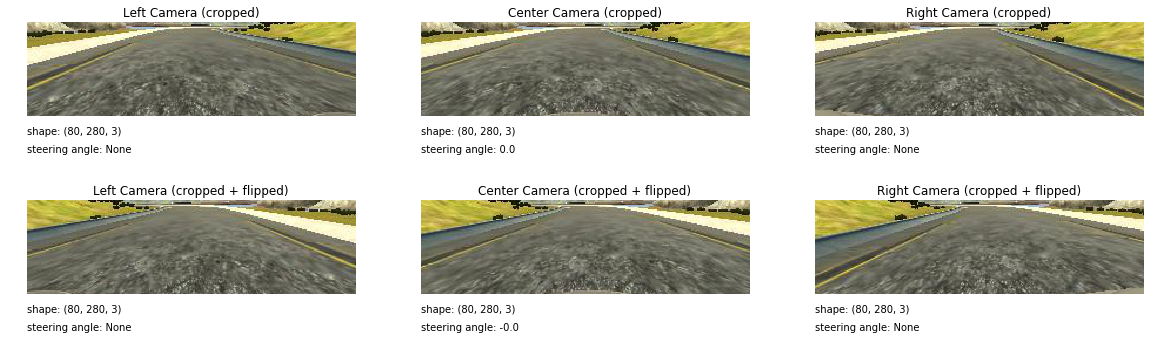

In [24]:
## Preview cropped and flipped images

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

# Select a random set of images to crop
center_img_crop = mpimg.imread(img_dir + udacity_data[index][0])[h1:h2,w1:w2]
left_img_crop = mpimg.imread(img_dir + udacity_data[index][1])[h1:h2,w1:w2]
right_img_crop = mpimg.imread(img_dir + udacity_data[index][2])[h1:h2,w1:w2]

# Create flipped versions
center_img_flip = cv2.flip(center_img_crop, 1)
left_img_flip = cv2.flip(left_img_crop, 1)
right_img_flip = cv2.flip(right_img_crop, 1)

# Calculate steering angles
center_steer = float(udacity_data[index][3])
left_steer = None
left_steer_flip = None 
right_steer = None
right_steer_flip = None
if center_steer > turn_thresh:
    left_steer = steer_adj(center_steer)
    left_steer_flip = -steer_adj(center_steer)
if center_steer < -turn_thresh:
    right_steer = steer_adj(center_steer)
    right_steer_flip = -steer_adj(center_steer)
    
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,6))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera (cropped)')
plt.text(0, left_img_crop.shape[0]+15, ('shape: ' + str(left_img_crop.shape)))
plt.text(0, left_img_crop.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera (cropped)')
plt.text(0, center_img_crop.shape[0]+15, ('shape: ' + str(center_img_crop.shape)))
plt.text(0, center_img_crop.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera (cropped)')
plt.text(0, right_img_crop.shape[0]+15, ('shape: ' + str(right_img_crop.shape)))
plt.text(0, right_img_crop.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_crop, cmap="gray")

# Flipped version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (cropped + flipped)')
plt.text(0, left_img_flip.shape[0]+15, ('shape: ' + str(left_img_flip.shape)))
plt.text(0, left_img_flip.shape[0]+30, ('steering angle: ' + str(left_steer_flip)))
plt.imshow(left_img_flip, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (cropped + flipped)')
plt.text(0, center_img_flip.shape[0]+15, ('shape: ' + str(center_img_flip.shape)))
plt.text(0, center_img_flip.shape[0]+30, ('steering angle: ' + str(-center_steer)))
plt.imshow(center_img_flip, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (cropped + flipped)')
plt.text(0, right_img_flip.shape[0]+15, ('shape: ' + str(right_img_flip.shape)))
plt.text(0, right_img_flip.shape[0]+30, ('steering angle: ' + str(right_steer_flip)))
plt.imshow(right_img_flip, cmap="gray")

#### Distribution after adding flipped version

In [ ]:
angles = [i[1] for i in track1_flip]
show_dist(angles)

### 2.5 | Image Smoothing

After reviewing the various smoothing techniques discussed [here in the OpenCV docs](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html), I decided to use `cv2.bilateralFilter()`. While the operation is slower than the other filters, it has the advantage of removing noise from the image **while preserving the edges**. A more in depth discussion on bilateral filtering can be found [here](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html) (University of Edinburgh). 

In [26]:
def img_smooth(image):
    blur_filter = (5, 80, 80)
    img_blur = cv2.bilateralFilter(image, blur_filter[0], blur_filter[1], blur_filter[2])
    
    return img_blur

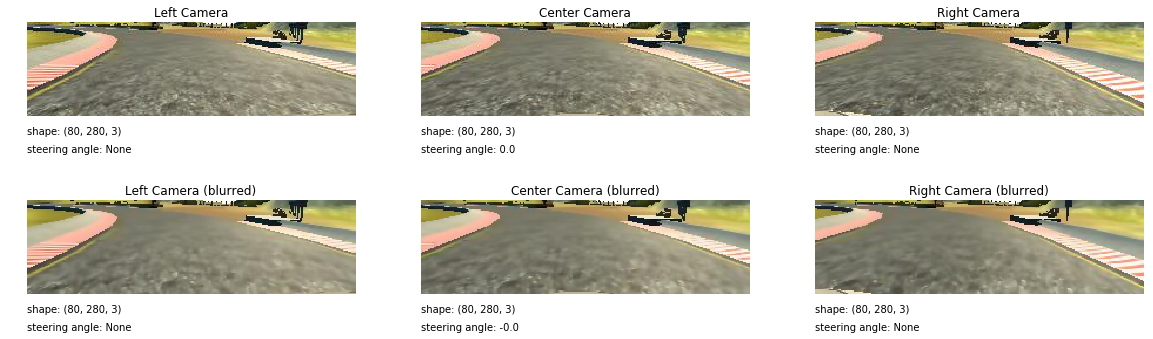

In [27]:
## Preview smoothed images

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

# Select a random set of images to crop
center_img_crop = mpimg.imread(img_dir + udacity_data[index][0])[h1:h2,w1:w2]
left_img_crop = mpimg.imread(img_dir + udacity_data[index][1])[h1:h2,w1:w2]
right_img_crop = mpimg.imread(img_dir + udacity_data[index][2])[h1:h2,w1:w2]

# Create smoothed versions
blur_filter = (5, 80, 80)
center_img_blur = img_smooth(center_img_crop)
left_img_blur = img_smooth(left_img_crop)
right_img_blur = img_smooth(right_img_crop)

# Calculate steering angles
center_steer = float(udacity_data[index][3])
left_steer = None
left_steer_blur = None 
right_steer = None
right_steer_blur = None
if center_steer > turn_thresh:
    left_steer = steer_adj(center_steer)
    left_steer_blur = -steer_adj(center_steer)
if center_steer < -turn_thresh:
    right_steer = steer_adj(center_steer)
    right_steer_blur = -steer_adj(center_steer)
    
# Display visualizations in the notebook
%matplotlib inline

plt.figure(figsize=(20,6))

# Cropped versions
plt.subplot2grid((2, 3), (0, 0));
plt.axis('off')
plt.title('Left Camera')
plt.text(0, left_img_crop.shape[0]+15, ('shape: ' + str(left_img_crop.shape)))
plt.text(0, left_img_crop.shape[0]+30, ('steering angle: ' + str(left_steer)))
plt.imshow(left_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 1));
plt.axis('off')
plt.title('Center Camera')
plt.text(0, center_img_crop.shape[0]+15, ('shape: ' + str(center_img_crop.shape)))
plt.text(0, center_img_crop.shape[0]+30, ('steering angle: ' + str(center_steer)))
plt.imshow(center_img_crop, cmap="gray")

plt.subplot2grid((2, 3), (0, 2));
plt.axis('off')
plt.title('Right Camera')
plt.text(0, right_img_crop.shape[0]+15, ('shape: ' + str(right_img_crop.shape)))
plt.text(0, right_img_crop.shape[0]+30, ('steering angle: ' + str(right_steer)))
plt.imshow(right_img_crop, cmap="gray")

# Flipped version
plt.subplot2grid((2, 3), (1, 0));
plt.axis('off')
plt.title('Left Camera (smoothed)')
plt.text(0, left_img_blur.shape[0]+15, ('shape: ' + str(left_img_blur.shape)))
plt.text(0, left_img_blur.shape[0]+30, ('steering angle: ' + str(left_steer_blur)))
plt.imshow(left_img_blur, cmap="gray")

plt.subplot2grid((2, 3), (1, 1));
plt.axis('off')
plt.title('Center Camera (smoothed)')
plt.text(0, center_img_blur.shape[0]+15, ('shape: ' + str(center_img_blur.shape)))
plt.text(0, center_img_blur.shape[0]+30, ('steering angle: ' + str(-center_steer)))
plt.imshow(center_img_blur, cmap="gray")

plt.subplot2grid((2, 3), (1, 2));
plt.axis('off')
plt.title('Right Camera (smoothed)')
plt.text(0, right_img_blur.shape[0]+15, ('shape: ' + str(right_img_blur.shape)))
plt.text(0, right_img_blur.shape[0]+30, ('steering angle: ' + str(right_steer_blur)))
plt.imshow(right_img_blur, cmap="gray")

### 2.6 | Create Equal Distribution

**NOTE**: I borrowed the function below from Jeremy Shannon ([source code](https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project/blob/master/model.py#L225)) with only minor modifications. 

In [87]:
def equal_dist(image_paths, angles, factor):
    '''Creates a more equalized distribution of steering angles.
    
    Basic logic:
    - If the number of samples in a given bin is below the target number, keep all samples for that bin.
    - Otherwise the keep prob for that bin is set to bring the number of samples for that bin down to the average.
    
    '''
    
    num_bins = 35
    avg_samples_per_bin = angles.shape[0] / num_bins
    target = avg_samples_per_bin * factor

    hist, bins = np.histogram(angles, num_bins)
    
    # Determine keep probability for each bin
    keep_probs = []
    for i in range(num_bins):
        if hist[i] <= target:
            keep_probs.append(1.)
        else:
            keep_prob = 1./(hist[i]/target)
            keep_probs.append(keep_prob)
    
    # Create list of angles to remove because bin count is above the target
    remove_list = []
    for i in range(len(angles)):
        for j in range(num_bins):
            if angles[i] >= bins[j] and angles[i] <= bins[j+1]:
                # delete with probability 1 - keep_probs[j]
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)

    image_paths_eq = np.delete(image_paths, remove_list, axis=0)
    angles_eq = np.delete(angles, remove_list)
    
    return image_paths_eq, angles_eq

#### Current Distribution &mdash; Track 1 Data

Total records: 10330
Avg per bin: 295.1


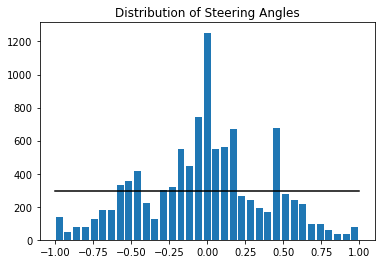

In [105]:
track1_images = np.array([i[0] for i in track1_3cam])
track1_angles = np.array([i[1] for i in track1_3cam])
show_dist(track1_angles)

#### New Distribution &mdash; Track 1 Data

Total records: 1983
Avg per bin: 56.7


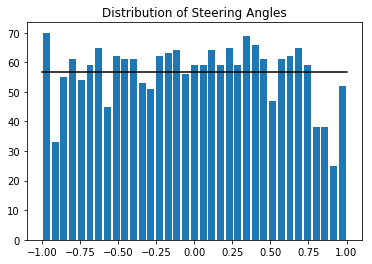

Records removed: 8347


In [108]:
track1_images_eq, track1_angles_eq = equal_dist(image_paths_track1, angles_track1, 0.2)
show_dist(track1_angles_eq)
print('Records removed:', track1_angles.shape[0]-track1_angles_eq.shape[0])

---

## Step 4: Setup Data Generator + Further Augmentation

### 2.6 | Change Brightness

Generates batches of tensor image data that is augmented based on a chosen set of tranformation parameters (e.g. rotation, shift, shear, zoom).

In [ ]:
# datagen_3 = ImageDataGenerator(featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=True,
#     zca_epsilon=1e-6,
#     rotation_range=2.,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.01,
#     zoom_range=0.,
#     channel_shift_range=0.1,
#     fill_mode='nearest',
#     cval=0.,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
#     preprocessing_function=None)

In [80]:
# Randomly shift brightness

def brightness(image):
    # Convert to HSV from RGB 
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Generate random brightness
    rand = random.uniform(0.4, 1)
    hsv[:,:,2] = rand*hsv[:,:,2]
    
    # Convert back to RGB 
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return new_img 

In [81]:
# Randomly shift horizon

def horizon(image):
    h, w, _ = image.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8,h/8)
    pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
    pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(image,M,(w,h), borderMode=cv2.BORDER_REPLICATE)
    
    return new_img

In [82]:
# Combine the brightness and horizon functions so they can be executed within the Keras ImageDataGenerator

def bright_horizon(image):
    bright_img = brightness(image)
    new_img = horizon(bright_img)
    
    return new_img

In [83]:
# Image transformation function

image = np.empty((160, 320, 3), dtype='uint8')

keras_datagen = ImageDataGenerator(
#     zca_whitening=True,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     shear_range=0.5,
#     zoom_range=0.15,
#     channel_shift_range=10.0,
    fill_mode='nearest',
    preprocessing_function=bright_horizon
)


In [ ]:
## Create AUGMENTED training sets **WORKING VERSION**

sample = random.sample(range(1, len(udacity_3cam)), 16)

X_batch = [(udacity_3cam[i][0], udacity_3cam[i][2]) for i in sample]
y_batch = [udacity_3cam[i][1] for i in sample]

X_images = np.empty((0, 160, 320, 3), dtype='uint8')
y_angles = np.empty(0, dtype='float32')

source = default_source

for i in range(len(y_batch)):
    # retrieve the image from local directory
    source = str(X_batch[i][1])
    filename = str(X_batch[i][0])
    img_path = get_img_dir(source) + filename
    img = [mpimg.imread(img_path.strip())]
    angle = [y_batch[i]]
    X_images = np.append(X_images, img, axis=0)
    y_angles = np.append(y_angles, angle, axis=0) 
    
X_aug = np.empty((0, 160, 320, 3))
y_aug = np.empty(0, dtype='float32')

print('Augmenting Image Data...')

# seed = random.randint(1, len(y_batch))
# datagen.fit(X_images)

for X,y in keras_datagen.flow(X_images, y_angles, batch_size=len(y_batch)):       
    X_aug = np.append(X_aug, X, axis=0)
    y_aug = np.append(y_aug, y, axis=0)
    
    if len(y_aug) == len(y_batch):
        break

X_aug = X_aug.astype(np.uint8)

print('Augmentation Complete.')



In [84]:
## Transformation function ** V 2 **
 
def transform(X_batch, y_batch):
    '''Applies a random set of transformations which are defined by the 
    keras_datagen() function and uses the Keras ImageDataGenerator.
    
    Arguments:
    X_batch: a numpy array of images
    y_batch: a numpy array of steering angles
        
    Returns:
    X_aug: a numpy array of transformed image data
    y_aug: a numpy array of steering angles

    '''
    X_aug = np.empty((0, 160, 320, 3))
    y_aug = np.empty(0, dtype='float32')
    
#     keras_datagen.fit(X_batch)

    for X,y in keras_datagen.flow(X_batch, y_batch, batch_size=len(y_batch)):       
        X_aug = np.append(X_aug, X, axis=0)
        y_aug = np.append(y_aug, y, axis=0)
        
        if X_aug.shape[0] == X_batch.shape[0]:
            break
    
    X_aug = X_aug.astype(np.uint8)
    
    return (X_aug, y_aug)

### 2.7 | Batch Generator

In [85]:
def generator(images, angles, source, val=False):
    '''Generates batches of images to feed into the model. 
    
    For each input image, four different versions are generated:
    img_1 : original version
    img_2 : flipped version of 1
    img_3 : version of 1 with other random transformations (for training only)
    img_4 : version of 2 with other random transformations (for training only)
    
    Arguments:
    images: a list of image filenames
    angles: a list of angles
    source: the original data source, 'udacity' or 'self'
    val: whether the data is being generated for validation (False by default)
    
    Yields: 
    X_batch: a numpy array of image data
    y_batch: a numpy array of steering angles
    
    '''
    images, angles = shuffle(images, angles, random_state=0)
    
    X_batch = np.empty((0, 160, 320, 3), dtype='uint8')
    y_batch = np.empty(0, dtype='float32')
    
    while True:
        for i in range(len(angles)):
            # retrieve the original image from local directory
#             img_path = get_img_dir(source) + str(images[i])
            img_path = get_img_dir(source) + images[i]
            img_1 = [mpimg.imread(img_path.strip())]
            ang_1 = [angles[i]]
            X_batch = np.append(X_batch, img_1, axis=0)
            y_batch = np.append(y_batch, ang_1, axis=0)

            # generate flipped version
            img_2 = [cv2.flip(img_1[0], 1)]
            ang_2 = [-angles[i]]
            X_batch = np.append(X_batch, img_2, axis=0)
            y_batch = np.append(y_batch, ang_2, axis=0)
            
            # augmentation process; for training images only
            if not val:
                # apply other transformations to img_1 and img_2
                imgs_3_4, angs_3_4 = transform(X_batch[-2:], y_batch[-2:])

                X_batch = np.append(X_batch, imgs_3_4, axis=0)
                y_batch = np.append(y_batch, angs_3_4, axis=0)
                
            if X_batch.shape[0] >= batch_size:
                X_batch, y_batch = shuffle(X_batch[0:batch_size], y_batch[0:batch_size])
                yield (X_batch, y_batch)
                X_batch = np.empty((0, 160, 320, 3), dtype='uint8')
                y_batch = np.empty(0, dtype='float32')

In [ ]:
## Display sample of the ORIGINAL training images

fig = plt.figure(figsize=(20,16))

orig_images = X_images
sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = orig_images[sample[i]]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

In [ ]:
## Display sample of training images with POSITIONAL SHIFTS (width, height rotation, horizon)

fig = plt.figure(figsize=(20,16)) 

sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = X_aug[i]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

In [ ]:
## Display sample of training images with BRIGHTNESS SHIFT 

fig = plt.figure(figsize=(20,16)) 

sample = random.sample(range(len(X_aug)), 16)

for i in range(16):
    img = X_aug[i]
    ax = fig.add_subplot(5,4,i+1)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.axis('off')
plt.show()

### 2.6 | Training and Validation sets


In [109]:
## Create training and validation sets ** EQUAL DIST **

X_train_self = list(track1_images_eq)     # list of image filenames
y_train_self = list(track1_angles_eq)     # list of angles

# Split training and testing data
X_train_self, X_valid_self, y_train_self, y_valid_self = \
                train_test_split(X_train_self, y_train_self, test_size=0.2, random_state=0)

# Number of training examples
n_train_self = len(X_train_self)

# Number of validation examples
n_valid_self = len(X_valid_self)

# Verify that all counts match
print("Number of training examples: ", n_train_self)
print("Number of validation examples: ", n_valid_self)


Number of training examples:  1586
Number of validation examples:  397


In [ ]:
# ## Create training and validation sets

# X_train_self = [(i[0], i[2]) for i in self_3cam]   # produces list of tuples [(image filename, source)]
# y_train_self = [i[1] for i in self_3cam]           # produces list of angles

# # Split training and testing data
# X_train_self, X_valid_self, y_train_self, y_valid_self = \
#                 train_test_split(X_train_self, y_train_self, test_size=0.2, random_state=0)

# # Split out source data
# src_train_self = [i[1] for i in X_train_self]
# X_train_self = [i[0] for i in X_train_self]

# src_valid_self = [i[1] for i in X_valid_self]
# X_valid_self = [i[0] for i in X_valid_self]


# # Number of training examples
# n_train_self = len(X_train_self)

# # Number of validation examples
# n_valid_self = len(X_valid_self)

# # Number of corresponding sources
# n_src_train_self = len(src_train_self)
# n_src_valid_self = len(src_valid_self)

# # Verify that all counts match
# print("Number of training examples: ", n_train_self)
# print("Number of validation examples: ", n_valid_self)
# print("Source counts: {} = {}, and {} = {} ".format(n_src_train_self, n_train_self, n_src_valid_self, n_valid_self))
# print("----------\nVerify Totals: {} = {} ".format((n_train_self+n_valid_self), len(self_3cam)))

---
## Step 3: Model Architecture
---

### Model

In [110]:
## Global variables and parameters

lr = 1e-4        # learning rate
reg = l2(1e-3)   # L2 reg
drop = 0.2       # default dropout rate

d_str = (2, 2)     # default strides
d_act = 'elu'      # default activation function
d_pad = 'same'     # default padding


In [94]:
## Model v7 - based on Comma.ai model
# https://github.com/commaai/research/blob/master/train_steering_model.py#L24

model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape=orig_shape))
model.add(Cropping2D(cropping=((60, 20), (20, 20))))

model.add(Conv2D(16, 8, strides=(4, 4), padding=d_pad, activation=d_act)) # ,  kernel_regularizer=reg)))
# model.add(ELU())
model.add(Conv2D(32, 5, strides=d_str, padding=d_pad, activation=d_act))
# model.add(ELU())
model.add(Conv2D(64, 5, strides=d_str, padding=d_pad, activation=d_act))

model.add(Flatten())
model.add(Dropout(.2))
model.add(Activation(d_act))
model.add(Dense(512))
model.add(Dropout(.5))
model.add(Activation(d_act))
model.add(Dense(1))

# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_5 (Cropping2D)    (None, 80, 280, 3)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 70, 16)        3088      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 35, 32)        12832     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 18, 64)         51264     
_________________________________________________________________
flatten_3 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5760)              0         
__________

In [ ]:
# ## Comma.ai model
# # https://github.com/commaai/research/blob/master/train_steering_model.py#L24

# def get_model(time_len=1):
#     ch, row, col = 3, 160, 320  # camera format

#     model = Sequential()
#     model.add(Lambda(lambda x: x/127.5 - 1.,
#             input_shape=(ch, row, col),
#             output_shape=(ch, row, col)))
#     model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
#     model.add(ELU())
#     model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
#     model.add(ELU())
#     model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
#     model.add(Flatten())
#     model.add(Dropout(.2))
#     model.add(ELU())
#     model.add(Dense(512))
#     model.add(Dropout(.5))
#     model.add(ELU())
#     model.add(Dense(1))

#     model.compile(optimizer="adam", loss="mse")

#     return model

In [ ]:
## Create and reset the model  ** V6 - NVIDIA ** 

model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape=orig_shape))
model.add(Cropping2D(cropping=((60, 20), (20, 20))))

model.add(Conv2D(32, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Conv2D(48, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Conv2D(64, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(80, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Conv2D(80, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(512, activation=act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(128, activation=act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(10, activation=act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(1))

# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

In [111]:
## Create and reset the model  ** V1 - NVIDIA ** 

model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape=orig_shape))
model.add(Cropping2D(cropping=((60, 20), (20, 20))))

model.add(Conv2D(24, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Conv2D(36, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Conv2D(48, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Conv2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(150, activation=act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(50, activation=act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(10, activation=act,  kernel_regularizer=reg))
# model.add(Dropout(drop))
model.add(Dense(1))

# Compile and preview the model
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_7 (Cropping2D)    (None, 80, 280, 3)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 40, 140, 24)       1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 70, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 35, 48)        43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 18, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 9, 64)          36928     
__________

## Training

In [112]:
## Train and save the model

MODEL_DIR = "models/"

source = 'track1'

epochs = 20
batch_size = 32

img_ratio = 4   # max is 4 based on generator output per input image

train_steps = (img_ratio * len(X_train_self)) // batch_size
val_steps = len(X_valid_self) // batch_size

train_gen = generator(X_train_self, y_train_self, source=source, val=False)
val_gen = generator(X_valid_self, y_valid_self, source=source, val=True)

checkpoint = ModelCheckpoint('models/checkpoints/model_{epoch:02d}.h5')
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=1, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save("models/model.h5")
print("Model saved to disk")

Epoch 1/20
198/198 [==============================] - 42s - loss: 0.7426 - acc: 0.0354 - val_loss: 0.6736 - val_acc: 0.0365
Epoch 2/20
198/198 [==============================] - 42s - loss: 0.6650 - acc: 0.0382 - val_loss: 0.6127 - val_acc: 0.0573
Epoch 3/20
198/198 [==============================] - 42s - loss: 0.6147 - acc: 0.0377 - val_loss: 0.5749 - val_acc: 0.0391
Epoch 4/20
198/198 [==============================] - 41s - loss: 0.5663 - acc: 0.0428 - val_loss: 0.5436 - val_acc: 0.0677
Epoch 5/20
198/198 [==============================] - 42s - loss: 0.5333 - acc: 0.0431 - val_loss: 0.5112 - val_acc: 0.0469
Epoch 6/20
198/198 [==============================] - 41s - loss: 0.5056 - acc: 0.0417 - val_loss: 0.4592 - val_acc: 0.0573
Epoch 7/20
198/198 [==============================] - 41s - loss: 0.4762 - acc: 0.0453 - val_loss: 0.4594 - val_acc: 0.0573
Epoch 8/20
198/198 [==============================] - 41s - loss: 0.4511 - acc: 0.0469 - val_loss: 0.4285 - val_acc: 0.0651
Epoch 9/

In [ ]:
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=1, callbacks=[checkpoint])


Epoch 1/20
 77/198 [==========>...................] - ETA: 25s - loss: 0.2770 - acc: 0.0621

In [97]:
## Train and save the model

MODEL_DIR = "models/"

source = 'track1'

epochs = 20
batch_size = 32

img_ratio = 4   # max is 4 based on generator output per input image

train_steps = (img_ratio * len(X_train_self)) // batch_size
val_steps = len(X_valid_self) // batch_size

train_gen = generator(X_train_self, y_train_self, source=source, val=False)
val_gen = generator(X_valid_self, y_valid_self, source=source, val=True)

checkpoint = ModelCheckpoint('models/checkpoints/model_{epoch:02d}.h5')
    
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, \
                    validation_data=val_gen, validation_steps=val_steps, verbose=1, callbacks=[checkpoint])

print('\nDone Training')

# Save model and weights
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save("models/model.h5")
print("Model saved to disk")

Epoch 1/20
414/414 [==============================] - 89s - loss: 0.1551 - acc: 0.0325 - val_loss: 0.1149 - val_acc: 0.0325
Epoch 2/20
414/414 [==============================] - 88s - loss: 0.1443 - acc: 0.0337 - val_loss: 0.1307 - val_acc: 0.0250
Epoch 3/20
414/414 [==============================] - 87s - loss: 0.1392 - acc: 0.0350 - val_loss: 0.1082 - val_acc: 0.0338
Epoch 4/20
414/414 [==============================] - 88s - loss: 0.1357 - acc: 0.0346 - val_loss: 0.1295 - val_acc: 0.0238
Epoch 5/20
414/414 [==============================] - 88s - loss: 0.1336 - acc: 0.0356 - val_loss: 0.1093 - val_acc: 0.0338
Epoch 6/20
414/414 [==============================] - 88s - loss: 0.1300 - acc: 0.0356 - val_loss: 0.1340 - val_acc: 0.0250
Epoch 7/20
414/414 [==============================] - 87s - loss: 0.1281 - acc: 0.0360 - val_loss: 0.1125 - val_acc: 0.0362
Epoch 8/20
414/414 [==============================] - 87s - loss: 0.1248 - acc: 0.0373 - val_loss: 0.1374 - val_acc: 0.0238
Epoch 9/

KeyboardInterrupt: 